In [1]:
import time
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

import classes.racetrack_list as rlist
from classes.action import Action
from classes.game import Game
from classes.model import ModelRLMC
from classes.state import State

In [18]:
sns.set_theme()

## Train model & collect statistics

In [3]:
def get_reward_of_episode(episode: list[tuple[State, Action, int]]):
    total_reward = 0
    for i, (state, action, reward) in enumerate(episode):
        total_reward += reward
    return total_reward

In [4]:
def simulate_train(track: np.ndarray, epsilon: float) -> tuple[pd.DataFrame, list[ModelRLMC]]:
    # how many models to train, how many episodes per model
    game = Game(racetrack=track, visualize=False, random_state=42)

    train_times = np.zeros(10)
    # dimensions: n_model, n_game, n_steps, reward
    stats_per_game_and_model: list[tuple[int, int, int, int]] = []
    models: list[ModelRLMC] = []

    for i in range(10):
        model = ModelRLMC(random_state=42)
        start = time.time()
        for j in range(0, 1000):
            episode: list[tuple[State, Action, int]] = []
            n_steps = 0
            while not game.is_finished() and n_steps < 1000:
                state = game.get_state()
                action = model.determine_epsilon_action(state, epsilon)
                reward = game.step(action)
                episode.append((state, action, reward))
                n_steps += 1
            model.learn(episode)
            game.reset()

            total_reward = get_reward_of_episode(episode)
            stats_per_game_and_model.append((i,j,n_steps,total_reward))
        end = time.time()
        train_times[i] = end - start
        models.append(model)

    df = pd.DataFrame(stats_per_game_and_model, columns=["n_model","n_games","n_steps","reward"])
    df["epsilon"] = epsilon
    return (df, models)

In [5]:
def simulate_test(track: np.ndarray, models: list[ModelRLMC], epsilon: float) -> pd.DataFrame:
    # how many models to train, how many episodes per model
    game = Game(racetrack=track, visualize=False, random_state=42)

    # dimensions:  n_game, n_steps, reward
    stats_per_game_and_model: list[tuple[int, int, int, int]] = []

    for i, model in enumerate(models):
        for j in range(0, 100):
            episode: list[tuple[State, Action, int]] = []
            n_steps = 0
            while not game.is_finished() and n_steps < 1000:
                state = game.get_state()
                action = model.determine_best_action(state)
                reward = game.step(action)
                episode.append((state, action, reward))
                n_steps += 1
            game.reset()
            total_reward = get_reward_of_episode(episode)
            stats_per_game_and_model.append((i,j,n_steps,total_reward))

    df = pd.DataFrame(stats_per_game_and_model, columns=["n_model","n_games","n_steps","reward"])
    df["epsilon"] = epsilon
    return df

In [6]:
def lowess_grouped(data: pd.DataFrame, x_name: str | tuple[str,...], y_name: str | tuple[str,...], group_name, frac: float):
    df = data.copy()

    if type(y_name) is str:
        y_name_smoothed = y_name + "_smooth"
    elif type(y_name) is tuple:
        y_name_smoothed = (y_name[0]+"_smooth",) + (y_name[1:])
    else:
        raise Exception("type of y_name not supported")

    if group_name is not None:
        groups = df[group_name].unique().tolist()
        smoothed_dfs = []
        for group in groups:
            df_by_select_group = df[df[group_name] == group]
            smoothed_df = sm.nonparametric.lowess(df_by_select_group[y_name],df_by_select_group[x_name],frac=frac)
            smoothed_df = pd.DataFrame(smoothed_df)
            smoothed_df.columns = [x_name, y_name_smoothed]
            smoothed_df[x_name] = smoothed_df[x_name].astype(int)
            smoothed_df[group_name] = group
            smoothed_dfs.append(smoothed_df)
        return pd.merge(df,pd.concat(smoothed_dfs), how="left", on=[x_name,group_name])
    else:
        smoothed_df = sm.nonparametric.lowess(df[y_name], df[x_name], frac=frac)
        smoothed_df = pd.DataFrame(smoothed_df)
        smoothed_df.columns = [x_name, y_name_smoothed]
        return pd.merge(df,smoothed_df, how="left", on=x_name)

In [7]:
track1 = rlist.get_track1()
track2 = rlist.get_track2()

Train and test models using epsilon of 0% and 10%.

In [8]:
stats_train_e0, models_e0 = simulate_train(track1, epsilon=0)
stats_train_e10, models_e10 = simulate_train(track1, epsilon=0.1)

In [9]:
stats_test_e0 = simulate_test(track1, models_e0, epsilon=0)
stats_test_e10 = simulate_test(track1, models_e10, epsilon=0.1)

Aggregate and smooth train and test data

In [10]:
# ignore warnings from function lowess_grouped()
with warnings.catch_warnings():
    warnings.simplefilter('ignore')

    stats_test = pd.concat([stats_test_e0,stats_test_e10])
    stats_test = stats_test.groupby(["epsilon","n_games"]).aggregate({'reward':['median','min','max']}).reset_index()
    stats_test = lowess_grouped(stats_test, y_name=("reward","median"), x_name=("n_games",""), group_name="epsilon", frac=0.07)
    stats_test = lowess_grouped(stats_test, y_name=("reward","min"), x_name=("n_games",""), group_name="epsilon", frac=0.07)
    stats_test = lowess_grouped(stats_test, y_name=("reward","max"), x_name=("n_games",""), group_name="epsilon", frac=0.07)

    stats_train = pd.concat([stats_train_e0,stats_train_e10])
    stats_train = stats_train.groupby(["epsilon","n_games"]).aggregate({'reward':['median','min','max']}).reset_index()
    stats_train = lowess_grouped(stats_train, y_name=("reward","median"), x_name=("n_games",""), group_name="epsilon", frac=0.07)
    stats_train = lowess_grouped(stats_train, y_name=("reward","min"), x_name=("n_games",""), group_name="epsilon", frac=0.07)
    stats_train = lowess_grouped(stats_train, y_name=("reward","max"), x_name=("n_games",""), group_name="epsilon", frac=0.07)

## Reward per Episode (when training)

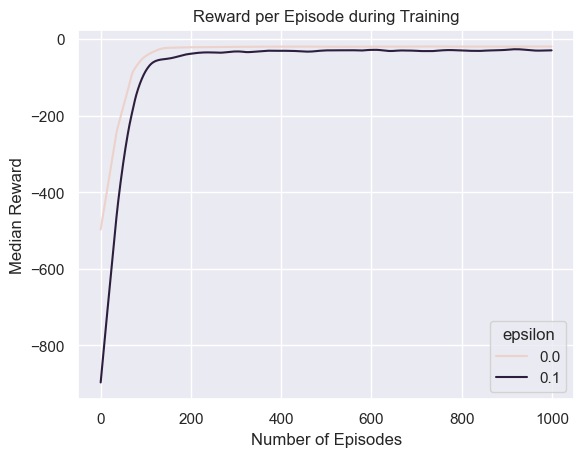

In [23]:
g = sns.lineplot(stats_train,x=("n_games",""),y=("reward_smooth","median"),hue="epsilon");
g.set(title='Reward per Episode during Training', xlabel='Number of Episodes', ylabel='Median Reward');

## Reward per Episode (when Testing)

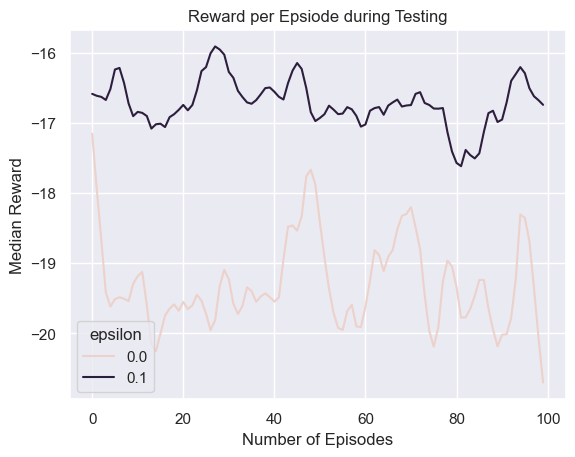

In [24]:
g = sns.lineplot(stats_test,x=("n_games",""),y=("reward_smooth","median"),hue="epsilon")
g.set(title='Reward per Episode during Testing', xlabel='Number of Episodes', ylabel='Median Reward');

In [13]:
stats_smoothed_e0 = stats_test[(stats_test["epsilon"]==0.0)]
stats_smoothed_e10 = stats_test[(stats_test["epsilon"]==0.1)]

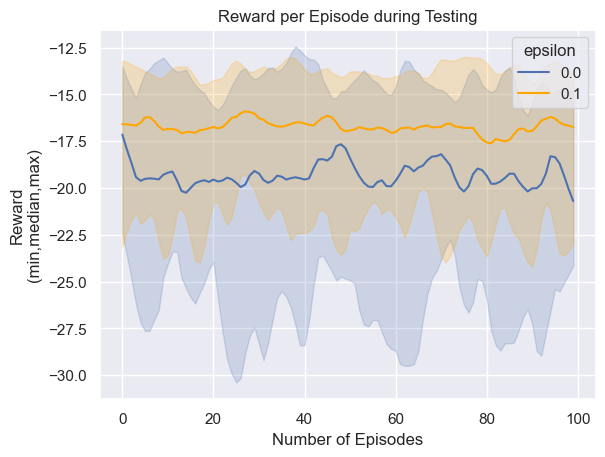

In [34]:
plt.plot(stats_smoothed_e0[("n_games","")],stats_smoothed_e0[("reward_smooth","median")], label="0.0")
plt.fill_between(stats_smoothed_e0[("n_games","")],stats_smoothed_e0[("reward_smooth","min")],stats_smoothed_e0[("reward_smooth","max")],color="b",alpha=0.2)
plt.plot(stats_smoothed_e10[("n_games","")],stats_smoothed_e10[("reward_smooth","median")],color="orange", label="0.1")
plt.fill_between(stats_smoothed_e10[("n_games","")],stats_smoothed_e10[("reward_smooth","min")],stats_smoothed_e10[("reward_smooth","max")],color="orange",alpha=0.2)
plt.xlabel("Number of Episodes")
plt.ylabel("Reward\n(min,median,max)")
plt.title("Reward per Episode during Testing")
plt.legend(title="epsilon");

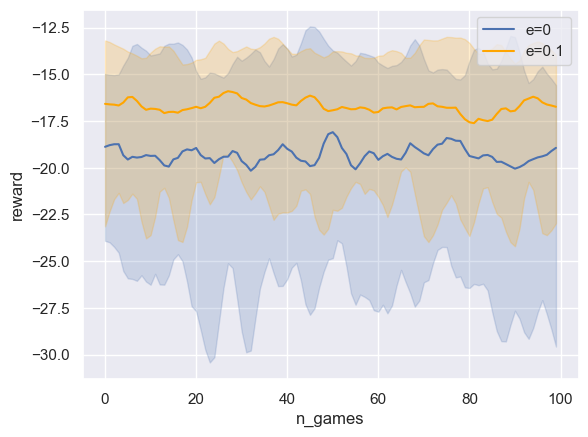

In [245]:
plt.plot(stats_smoothed_e0[("n_games","")],stats_smoothed_e0[("reward_smooth","median")], label="e=0")
plt.fill_between(stats_smoothed_e0[("n_games","")],stats_smoothed_e0[("reward_smooth","min")],stats_smoothed_e0[("reward_smooth","max")],color="b",alpha=0.2)

plt.plot(stats_smoothed_e10[("n_games","")],stats_smoothed_e10[("reward_smooth","median")],color="orange", label="e=0.1")
plt.fill_between(stats_smoothed_e10[("n_games","")],stats_smoothed_e10[("reward_smooth","min")],stats_smoothed_e10[("reward_smooth","max")],color="orange",alpha=0.2)
plt.xlabel("n_games")
plt.ylabel("reward");
plt.legend();